Unzip File

In [ ]:
!unzip '/content/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

###Importing Dependencies

In [40]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.preprocessing import image

Set Constraints

In [41]:
IMAGE_SIZE = [176, 208]
EPOCHS = 100

###Loading Dataset

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Alzheimer_s Dataset/train',
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = 32
)

vals_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Alzheimer_s Dataset/train',
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = 32,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [43]:
classes = ['MildDementia', 'MorderateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = classes
vals_ds.class_names = classes
NUM_CLASSES = len(classes)

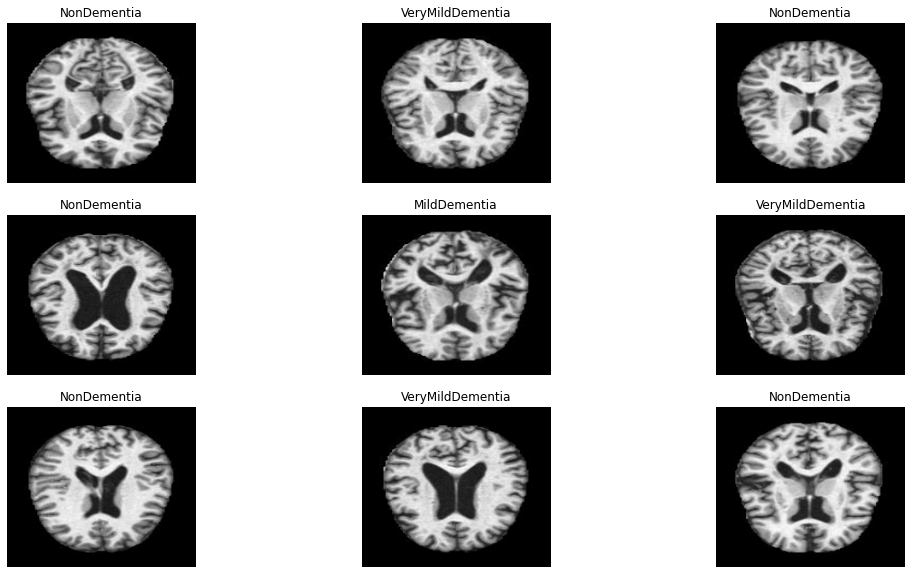

In [44]:
plt.figure(figsize = (18, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')


Using one hot encoding 

In [45]:
train_ds.map(lambda x, y: (tf.cast(x, tf.int16), y))
vals_ds.map(lambda x, y: (tf.cast(x, tf.int16), y))

<MapDataset element_spec=(TensorSpec(shape=(None, 176, 208, 3), dtype=tf.int16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
def one_hot_label(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

train_ds = train_ds.map(one_hot_label)
vals_ds = vals_ds.map(one_hot_label)

###Building the Model

In [47]:
def conv_blocks(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])
  return block

def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation = 'relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])
  return block

In [48]:
def build_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape = (*IMAGE_SIZE, 3)),
      tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPool2D(),
      conv_blocks(32),
      conv_blocks(64),
      conv_blocks(128),
      tf.keras.layers.Dropout(0.2),
      conv_blocks(256),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      dense_block(512, 0.7),
      dense_block(128, 0.5),
      dense_block(64, 0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
  ])
  return model

In [49]:
model = build_model()
METRICS = [tf.keras.metrics.AUC(name = 'auc')]
model.compile(
    optimizer = 'adam',
    loss = tf.losses.CategoricalCrossentropy(),
    metrics = METRICS
)

###Training the Model

In [50]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0*0.1**(epoch/s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)


In [51]:
history = model.fit(train_ds,
                    validation_data = vals_ds,
                    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],
                    epochs = EPOCHS
                    )

Epoch 1/100
129/129 [==============================] - 20s 140ms/step - loss: 1.1247 - auc: 0.7768 - val_loss: 13.9366 - val_auc: 0.6671 - lr: 0.0100
Epoch 2/100
129/129 [==============================] - 18s 140ms/step - loss: 0.9778 - auc: 0.8098 - val_loss: 1.1139 - val_auc: 0.7167 - lr: 0.0089
Epoch 3/100
129/129 [==============================] - 17s 133ms/step - loss: 0.9564 - auc: 0.8173 - val_loss: 1.4306 - val_auc: 0.7988 - lr: 0.0079
Epoch 4/100
129/129 [==============================] - 17s 130ms/step - loss: 0.9573 - auc: 0.8169 - val_loss: 1.1933 - val_auc: 0.6388 - lr: 0.0071
Epoch 5/100
129/129 [==============================] - 17s 134ms/step - loss: 0.9437 - auc: 0.8229 - val_loss: 2.8404 - val_auc: 0.7296 - lr: 0.0063
Epoch 6/100
129/129 [==============================] - 18s 136ms/step - loss: 0.9328 - auc: 0.8277 - val_loss: 1.3251 - val_auc: 0.8093 - lr: 0.0056
Epoch 7/100
129/129 [==============================] - 17s 132ms/step - loss: 0.9286 - auc: 0.8303 - val_

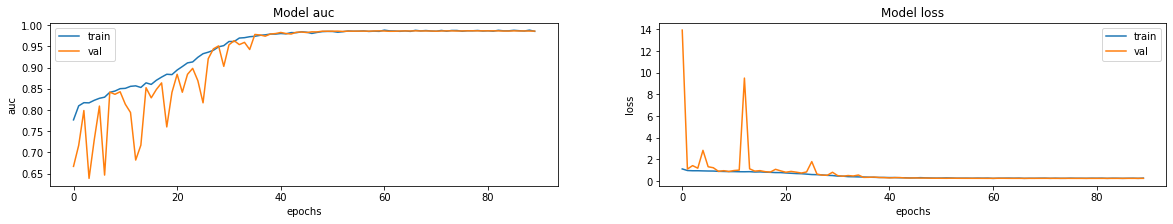

In [54]:
fig, ax = plt.subplots(1, 2, figsize = (20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

In [55]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Alzheimer_s Dataset/test',
                                                              image_size = IMAGE_SIZE,
                                                              batch_size = 32)
test_ds =  test_ds.map(one_hot_label)
_ = model.evaluate(test_ds)

Found 1279 files belonging to 4 classes.
40/40 [==============================] - 1s 25ms/step - loss: 1.0432 - auc: 0.8777


Testing Model

In [56]:
new_model = tf.keras.models.load_model('alzheimer_model.h5')

In [58]:
_ = new_model.evaluate(test_ds)

40/40 [==============================] - 2s 27ms/step - loss: 1.0432 - auc: 0.8777


In [77]:
img_path = '/content/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg'
img = image.load_img(img_path, target_size= [176, 208])

In [78]:
img = image.img_to_array(img)
arr = np.array([img])

In [79]:
arr.shape

(1, 176, 208, 3)

In [80]:

prediction = new_model.predict(arr)

1/1 [==============================] - 0s 286ms/step


In [81]:
print(prediction)

[[0.8388886  0.02947104 0.00259219 0.1290482 ]]
